# ERA5 Climate Data Exploration for Brazil
## Temperature-Mortality Research

This notebook explores ERA5 reanalysis data downloaded for Brazil (2021-2024) to study the relationship between temperature and mortality in older populations.

### Variables in the dataset:
- **2m_temperature (t2m)**: Air temperature at 2 meters above ground (Kelvin)
- **2m_dewpoint_temperature (d2m)**: Dewpoint temperature (Kelvin) - for humidity calculations
- **10m wind components (u10, v10)**: Wind speed components (m/s)
- **surface_pressure (sp)**: Surface pressure (Pa)

In [58]:
# Import Required Libraries
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load the ERA5 Dataset

In [59]:
# Load the 2021 ERA5 data as an example
ds = xr.open_dataset('era5_brazil_hourly_2021.nc')

# Display the dataset structure
print("Dataset Overview:")
print("=" * 60)
ds

Dataset Overview:


<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2920, latitude: 161, longitude: 161)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 23kB 2021-01-01 ... 2021-12-31T21...
  * latitude    (latitude) float64 1kB 6.0 5.75 5.5 5.25 ... -33.5 -33.75 -34.0
  * longitude   (longitude) float64 1kB -74.0 -73.75 -73.5 ... -34.25 -34.0
    number      int64 8B ...
    expver      (valid_time) <U4 47kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 303MB ...
    d2m         (valid_time, latitude, longitude) float32 303MB ...
    u10         (valid_time, latitude, longitude) float32 303MB ...
    v10         (valid_time, latitude, longitude) float32 303MB ...
    sp          (valid_time, latitude, longitude) float32 303MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-04T17:24 GRIB to CDM+CF via cfgrib-0.9.1...

## 2. Examine Dataset Dimensions and Coordinates

In [60]:
# Dataset dimensions
print("Dimensions:")
for dim, size in ds.sizes.items():
    print(f"  {dim}: {size}")

print("\nCoordinate ranges:")
print(f"  Time: {ds.valid_time.values[0]} to {ds.valid_time.values[-1]}")
print(f"  Latitude: {ds.latitude.values.min():.2f}° to {ds.latitude.values.max():.2f}°")
print(f"  Longitude: {ds.longitude.values.min():.2f}° to {ds.longitude.values.max():.2f}°")

print("\nVariables:")
for var in ds.data_vars:
    print(f"  {var}: {ds[var].attrs.get('long_name', var)} [{ds[var].attrs.get('units', 'N/A')}]")

Dimensions:
  valid_time: 2920
  latitude: 161
  longitude: 161

Coordinate ranges:
  Time: 2021-01-01T00:00:00.000000000 to 2021-12-31T21:00:00.000000000
  Latitude: -34.00° to 6.00°
  Longitude: -74.00° to -34.00°

Variables:
  t2m: 2 metre temperature [K]
  d2m: 2 metre dewpoint temperature [K]
  u10: 10 metre U wind component [m s**-1]
  v10: 10 metre V wind component [m s**-1]
  sp: Surface pressure [Pa]


## 3. Temperature Statistics (Converting from Kelvin to Celsius)

In [61]:
# Convert temperature from Kelvin to Celsius
t2m_celsius = ds['t2m'] - 273.15

# Calculate basic statistics across all data
print("2m Temperature Statistics (°C) - Full year 2021:")
print("=" * 50)
print(f"  Mean:    {float(t2m_celsius.mean()):.2f}°C")
print(f"  Std Dev: {float(t2m_celsius.std()):.2f}°C")
print(f"  Min:     {float(t2m_celsius.min()):.2f}°C")
print(f"  Max:     {float(t2m_celsius.max()):.2f}°C")

2m Temperature Statistics (°C) - Full year 2021:
  Mean:    22.94°C
  Std Dev: 6.39°C
  Min:     -40.28°C
  Max:     46.90°C
  Std Dev: 6.39°C
  Min:     -40.28°C
  Max:     46.90°C


## 4. Visualize Spatial Temperature Distribution

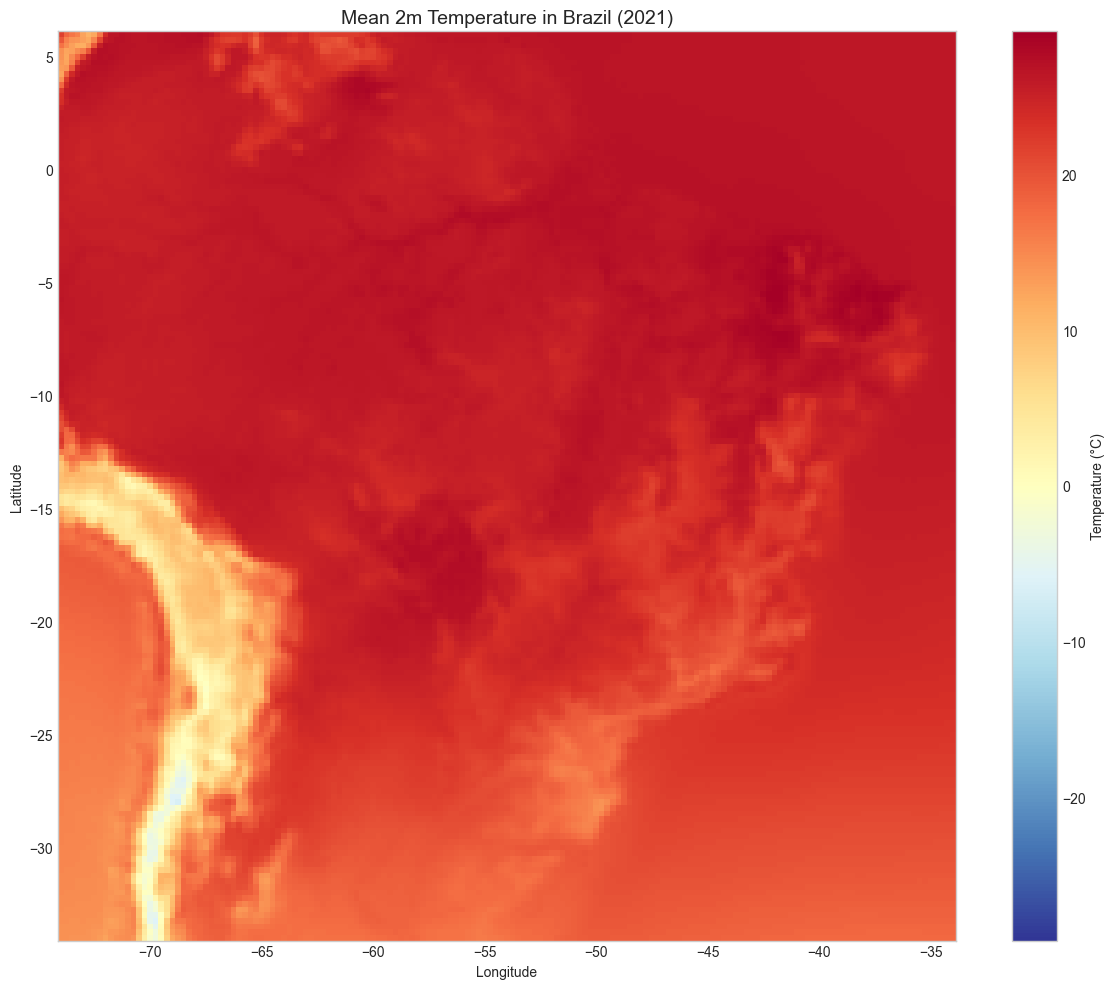

In [62]:
# Calculate mean temperature across time for each grid point
mean_temp = (ds['t2m'].mean(dim='valid_time') - 273.15)

# Plot spatial distribution of mean temperature
fig, ax = plt.subplots(figsize=(12, 10))
im = mean_temp.plot(ax=ax, cmap='RdYlBu_r', cbar_kwargs={'label': 'Temperature (°C)'})
ax.set_title('Mean 2m Temperature in Brazil (2021)', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

## 5. Time Series Analysis - Daily Mean Temperature

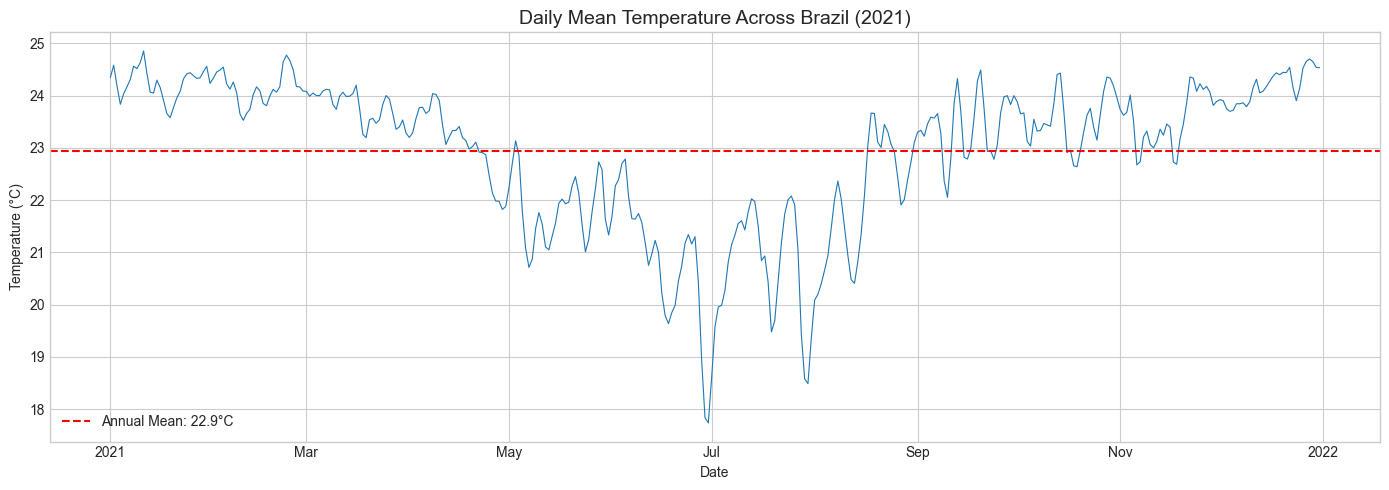

In [63]:
# Calculate daily mean temperature (averaged across all Brazil)
daily_temp = (ds['t2m'] - 273.15).resample(valid_time='1D').mean()
brazil_daily_mean = daily_temp.mean(dim=['latitude', 'longitude'])

# Plot time series
fig, ax = plt.subplots(figsize=(14, 5))
brazil_daily_mean.plot(ax=ax, linewidth=0.8)
ax.set_title('Daily Mean Temperature Across Brazil (2021)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.axhline(y=float(brazil_daily_mean.mean()), color='red', linestyle='--', label=f'Annual Mean: {float(brazil_daily_mean.mean()):.1f}°C')
ax.legend()
plt.tight_layout()
plt.show()

## 6. Calculate Heat Index / Apparent Temperature

The Heat Index combines temperature and humidity to measure how hot it actually feels. This is crucial for mortality studies as high humidity prevents the body from cooling through sweating.

In [64]:
# Calculate relative humidity from temperature and dewpoint
# Using the Magnus formula
def calc_relative_humidity(t2m_celsius, d2m_celsius):
    """Calculate relative humidity from temperature and dewpoint (both in Celsius)"""
    # Saturation vapor pressure
    e_s = 6.112 * np.exp((17.67 * t2m_celsius) / (t2m_celsius + 243.5))
    e_d = 6.112 * np.exp((17.67 * d2m_celsius) / (d2m_celsius + 243.5))
    rh = 100 * (e_d / e_s)
    return rh

# Convert temperatures
t2m_c = ds['t2m'] - 273.15
d2m_c = ds['d2m'] - 273.15

# Calculate relative humidity
rh = calc_relative_humidity(t2m_c, d2m_c)

print("Relative Humidity Statistics (%):")
print(f"  Mean: {float(rh.mean()):.1f}%")
print(f"  Min:  {float(rh.min()):.1f}%")
print(f"  Max:  {float(rh.max()):.1f}%")

Relative Humidity Statistics (%):
  Mean: 74.5%
  Min:  2.0%
  Max:  100.0%
  Mean: 74.5%
  Min:  2.0%
  Max:  100.0%


## 7. Temperature Distribution Histogram

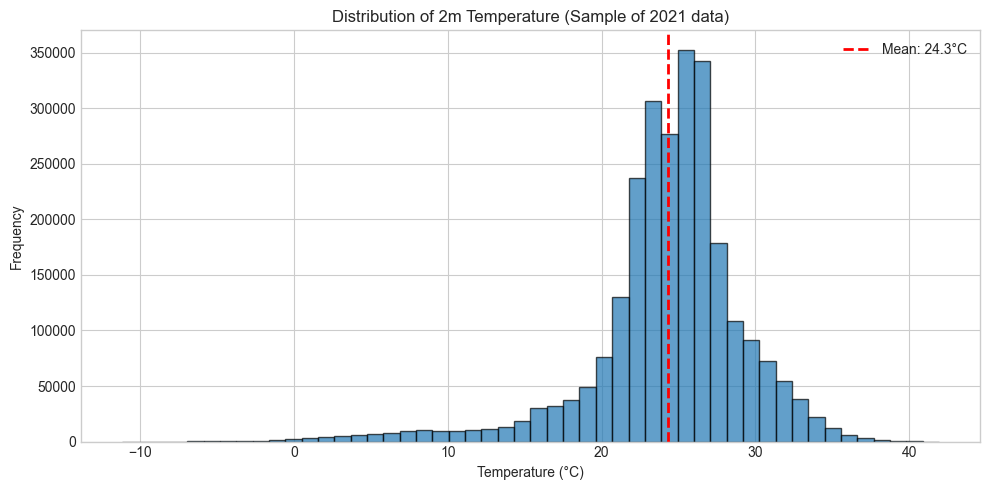

In [65]:
# Sample data for histogram (too large to plot all)
temp_sample = t2m_c.isel(valid_time=slice(0, 100)).values.flatten()
temp_sample = temp_sample[~np.isnan(temp_sample)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(temp_sample, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=np.mean(temp_sample), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(temp_sample):.1f}°C')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of 2m Temperature (Sample of 2021 data)')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Export Daily Aggregated Data for Analysis

For mortality studies, you typically need daily-level data. Let's create a daily summary that can be merged with mortality data.

In [66]:
# Create daily aggregated data for Brazil (national average)
# This is useful for preliminary analysis

# Daily mean, min, max temperature
daily_data = pd.DataFrame({
    'date': pd.to_datetime(ds.valid_time.resample(valid_time='1D').mean().valid_time.values),
    'temp_mean': (ds['t2m'] - 273.15).resample(valid_time='1D').mean().mean(dim=['latitude', 'longitude']).values,
    'temp_max': (ds['t2m'] - 273.15).resample(valid_time='1D').max().mean(dim=['latitude', 'longitude']).values,
    'temp_min': (ds['t2m'] - 273.15).resample(valid_time='1D').min().mean(dim=['latitude', 'longitude']).values,
    'dewpoint_mean': (ds['d2m'] - 273.15).resample(valid_time='1D').mean().mean(dim=['latitude', 'longitude']).values,
})

# Add month for seasonal analysis
daily_data['month'] = daily_data['date'].dt.month
daily_data['day_of_year'] = daily_data['date'].dt.dayofyear

print("Daily Aggregated Data Preview:")
print(daily_data.head(10))
print(f"\nShape: {daily_data.shape}")

Daily Aggregated Data Preview:
        date  temp_mean   temp_max   temp_min  dewpoint_mean  month  \
0 2021-01-01  24.352369  28.303074  21.207205      19.289753      1   
1 2021-01-02  24.581230  28.333321  21.478695      19.415745      1   
2 2021-01-03  24.182419  27.503616  21.447990      19.458158      1   
3 2021-01-04  23.834188  27.223936  21.229033      19.706661      1   
4 2021-01-05  24.037609  27.501148  21.303488      19.836596      1   
5 2021-01-06  24.169043  27.587830  21.387329      19.842260      1   
6 2021-01-07  24.310425  27.921766  21.367773      19.830872      1   
7 2021-01-08  24.564892  28.303740  21.483271      19.834114      1   
8 2021-01-09  24.516685  28.225170  21.555683      19.949812      1   
9 2021-01-10  24.631907  28.260778  21.764830      20.157825      1   

   day_of_year  
0            1  
1            2  
2            3  
3            4  
4            5  
5            6  
6            7  
7            8  
8            9  
9           10  


## 9. Monthly Temperature Patterns

C:\Users\LucasSempe\AppData\Local\Temp\ipykernel_16272\2382026719.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([monthly_stats[m] for m in range(1, 13)], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',


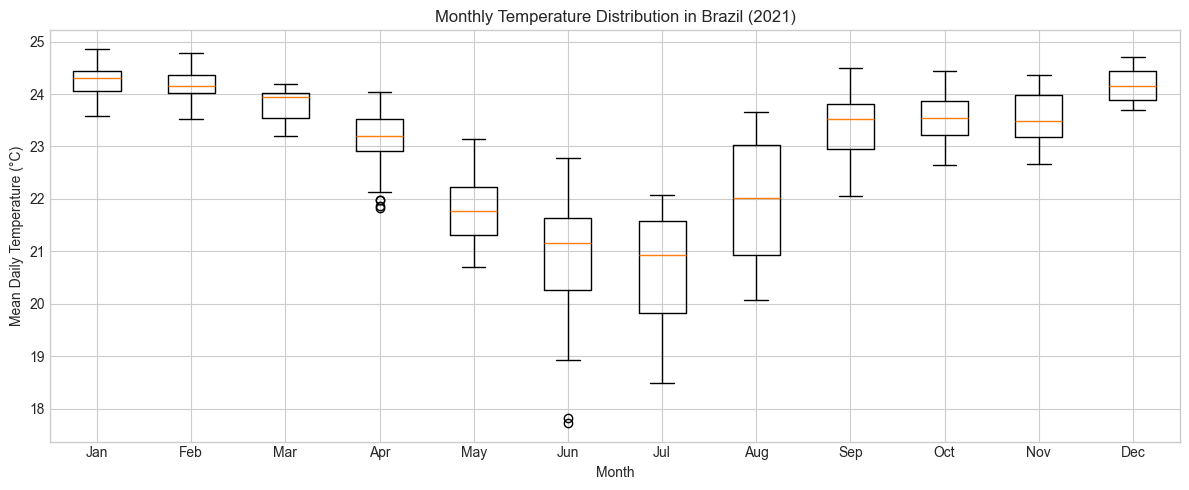


Monthly Mean Temperatures:
month
1     24.200001
2     24.200001
3     23.799999
4     23.100000
5     21.799999
6     20.900000
7     20.700001
8     22.000000
9     23.400000
10    23.600000
11    23.500000
12    24.200001
Name: temp_mean, dtype: float32


In [67]:
# Monthly boxplot
fig, ax = plt.subplots(figsize=(12, 5))
monthly_stats = daily_data.groupby('month')['temp_mean'].apply(list)

ax.boxplot([monthly_stats[m] for m in range(1, 13)], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Mean Daily Temperature (°C)')
ax.set_title('Monthly Temperature Distribution in Brazil (2021)')
plt.tight_layout()
plt.show()

# Print monthly means
print("\nMonthly Mean Temperatures:")
print(daily_data.groupby('month')['temp_mean'].mean().round(1))

## 10. Close Dataset

In [68]:
# Close the dataset to free memory
ds.close()

print("Dataset closed. Summary:")
print("=" * 50)
print("✓ Loaded ERA5 data for Brazil 2021")
print("✓ Examined temperature, dewpoint, wind, pressure")
print("✓ Created daily aggregated statistics")
print("✓ Visualized spatial and temporal patterns")
print("\nNext steps for mortality analysis:")
print("  1. Load mortality data by date/region")
print("  2. Aggregate ERA5 to matching spatial units (states/municipalities)")
print("  3. Merge temperature and mortality data")
print("  4. Run distributed lag non-linear models (DLNM)")

Dataset closed. Summary:
✓ Loaded ERA5 data for Brazil 2021
✓ Examined temperature, dewpoint, wind, pressure
✓ Created daily aggregated statistics
✓ Visualized spatial and temporal patterns

Next steps for mortality analysis:
  1. Load mortality data by date/region
  2. Aggregate ERA5 to matching spatial units (states/municipalities)
  3. Merge temperature and mortality data
  4. Run distributed lag non-linear models (DLNM)


---
# Overview of All Downloaded ERA5 Files

You have downloaded **12 NetCDF files** covering Brazil from 2021-2024, organized into 3 categories:

In [69]:
# List all NetCDF files and their sizes
import os
import glob

nc_files = glob.glob('*.nc')
print("Downloaded ERA5 NetCDF Files:")
print("=" * 70)

for f in sorted(nc_files):
    size_mb = os.path.getsize(f) / (1024 * 1024)
    print(f"  {f:45} {size_mb:8.1f} MB")

total_size = sum(os.path.getsize(f) for f in nc_files) / (1024 * 1024 * 1024)
print(f"\n  Total: {len(nc_files)} files, {total_size:.2f} GB")

Downloaded ERA5 NetCDF Files:
  era5_brazil_accumulated_2021.nc                  148.0 MB
  era5_brazil_accumulated_2022.nc                  146.2 MB
  era5_brazil_accumulated_2023.nc                  143.6 MB
  era5_brazil_accumulated_2024.nc                  141.7 MB
  era5_brazil_hourly_2021.nc                       678.8 MB
  era5_brazil_hourly_2022.nc                       677.1 MB
  era5_brazil_hourly_2023.nc                       679.4 MB
  era5_brazil_hourly_2024.nc                       681.4 MB
  era5_brazil_minmax_2021.nc                       240.2 MB
  era5_brazil_minmax_2022.nc                       240.6 MB
  era5_brazil_minmax_2023.nc                       240.4 MB
  era5_brazil_minmax_2024.nc                       241.9 MB

  Total: 12 files, 4.16 GB


## File Type 1: Hourly Data (`era5_brazil_hourly_YYYY.nc`)

Contains instantaneous measurements every 3 hours. These are your **core temperature variables**.

In [70]:
# Examine hourly data structure
ds_hourly = xr.open_dataset('era5_brazil_hourly_2021.nc')

print("HOURLY DATA - era5_brazil_hourly_YYYY.nc")
print("=" * 60)
print(f"\nDimensions: {dict(ds_hourly.sizes)}")
print(f"\nVariables:")
for var in ds_hourly.data_vars:
    attrs = ds_hourly[var].attrs
    print(f"  • {var}: {attrs.get('long_name', var)}")
    print(f"      Units: {attrs.get('units', 'N/A')}")

print(f"\nTime coverage: {ds_hourly.valid_time.values[0]} to {ds_hourly.valid_time.values[-1]}")
print(f"Time steps: {len(ds_hourly.valid_time)} (every 3 hours)")

ds_hourly.close()

HOURLY DATA - era5_brazil_hourly_YYYY.nc

Dimensions: {'valid_time': 2920, 'latitude': 161, 'longitude': 161}

Variables:
  • t2m: 2 metre temperature
      Units: K
  • d2m: 2 metre dewpoint temperature
      Units: K
  • u10: 10 metre U wind component
      Units: m s**-1
  • v10: 10 metre V wind component
      Units: m s**-1
  • sp: Surface pressure
      Units: Pa

Time coverage: 2021-01-01T00:00:00.000000000 to 2021-12-31T21:00:00.000000000
Time steps: 2920 (every 3 hours)


## File Type 2: Min/Max Temperature (`era5_brazil_minmax_YYYY.nc`)

Contains daily **maximum and minimum 2m temperature** - critical for identifying heat waves and cold spells that affect mortality.

In [71]:
# Examine min/max temperature data
ds_minmax = xr.open_dataset('era5_brazil_minmax_2021.nc')

print("MIN/MAX TEMPERATURE - era5_brazil_minmax_YYYY.nc")
print("=" * 60)
print(f"\nDimensions: {dict(ds_minmax.sizes)}")
print(f"\nVariables:")
for var in ds_minmax.data_vars:
    attrs = ds_minmax[var].attrs
    print(f"  • {var}: {attrs.get('long_name', var)}")
    print(f"      Units: {attrs.get('units', 'N/A')}")

# Show sample statistics
print(f"\nSample statistics (2021, national average):")
for var in ds_minmax.data_vars:
    temp_c = ds_minmax[var].mean(dim=['latitude', 'longitude']) - 273.15
    print(f"  {var}: Mean={float(temp_c.mean()):.1f}°C, Min={float(temp_c.min()):.1f}°C, Max={float(temp_c.max()):.1f}°C")

ds_minmax.close()

MIN/MAX TEMPERATURE - era5_brazil_minmax_YYYY.nc

Dimensions: {'valid_time': 2920, 'latitude': 161, 'longitude': 161}

Variables:
  • mx2t: Maximum temperature at 2 metres since previous post-processing
      Units: K
  • mn2t: Minimum temperature at 2 metres since previous post-processing
      Units: K

Sample statistics (2021, national average):
  mx2t: Mean=23.0°C, Min=15.1°C, Max=28.4°C
  mx2t: Mean=23.0°C, Min=15.1°C, Max=28.4°C
  mn2t: Mean=22.5°C, Min=14.9°C, Max=28.1°C
  mn2t: Mean=22.5°C, Min=14.9°C, Max=28.1°C


## File Type 3: Accumulated Variables (`era5_brazil_accumulated_YYYY.nc`)

Contains **precipitation** and **solar radiation** - potential confounders or effect modifiers in mortality analysis.

In [72]:
# Examine accumulated data (precipitation, radiation)
ds_accum = xr.open_dataset('era5_brazil_accumulated_2021.nc')

print("ACCUMULATED VARIABLES - era5_brazil_accumulated_YYYY.nc")
print("=" * 60)
print(f"\nDimensions: {dict(ds_accum.sizes)}")
print(f"\nVariables:")
for var in ds_accum.data_vars:
    attrs = ds_accum[var].attrs
    print(f"  • {var}: {attrs.get('long_name', var)}")
    print(f"      Units: {attrs.get('units', 'N/A')}")

print("\nNote on units:")
print("  • Precipitation (tp): in meters - multiply by 1000 for mm")
print("  • Solar radiation (ssrd): in J/m² - divide by 3600 for W/m²")

ds_accum.close()

ACCUMULATED VARIABLES - era5_brazil_accumulated_YYYY.nc

Dimensions: {'valid_time': 2920, 'latitude': 161, 'longitude': 161}

Variables:
  • tp: Total precipitation
      Units: m
  • ssrd: Surface short-wave (solar) radiation downwards
      Units: J m**-2

Note on units:
  • Precipitation (tp): in meters - multiply by 1000 for mm
  • Solar radiation (ssrd): in J/m² - divide by 3600 for W/m²


## Summary Table: All Variables for Mortality Research

In [74]:
# Create a summary of all variables across all file types
summary_data = [
    ["HOURLY FILES (era5_brazil_hourly_YYYY.nc)", "", "", ""],
    ["t2m", "2m Temperature", "K → °C (subtract 273.15)", "Main exposure variable"],
    ["d2m", "2m Dewpoint Temperature", "K → °C", "Calculate humidity/heat index"],
    ["u10", "10m U-wind component", "m/s", "Wind speed (eastward)"],
    ["v10", "10m V-wind component", "m/s", "Wind speed (northward)"],
    ["sp", "Surface Pressure", "Pa", "Atmospheric pressure"],
    ["", "", "", ""],
    ["MIN/MAX FILES (era5_brazil_minmax_YYYY.nc)", "", "", ""],
    ["mx2t", "Max 2m Temperature", "K → °C", "Heat wave detection"],
    ["mn2t", "Min 2m Temperature", "K → °C", "Cold spell detection"],
    ["", "", "", ""],
    ["ACCUMULATED FILES (era5_brazil_accumulated_YYYY.nc)", "", "", ""],
    ["tp", "Total Precipitation", "m → mm (×1000)", "Rainfall"],
    ["ssrd", "Surface Solar Radiation", "J/m² → W/m² (÷3600)", "Solar exposure"],
]

print("COMPLETE VARIABLE SUMMARY")
print("=" * 90)
print(f"{'Variable':<12} {'Description':<30} {'Unit Conversion':<25} {'Use in Research':<20}")
print("-" * 90)
for row in summary_data:
    if row[0] and not row[0].isupper():
        print(f"{row[0]:<12} {row[1]:<30} {row[2]:<25} {row[3]:<20}")
    elif row[0]:
        print(f"\n{row[0]}")
        print("-" * 90)

COMPLETE VARIABLE SUMMARY
Variable     Description                    Unit Conversion           Use in Research     
------------------------------------------------------------------------------------------
HOURLY FILES (era5_brazil_hourly_YYYY.nc)                                                                              
t2m          2m Temperature                 K → °C (subtract 273.15)  Main exposure variable
d2m          2m Dewpoint Temperature        K → °C                    Calculate humidity/heat index
u10          10m U-wind component           m/s                       Wind speed (eastward)
v10          10m V-wind component           m/s                       Wind speed (northward)
sp           Surface Pressure               Pa                        Atmospheric pressure
MIN/MAX FILES (era5_brazil_minmax_YYYY.nc)                                                                              
mx2t         Max 2m Temperature             K → °C                    Heat wave de

## Spatial Identifiers in ERA5 Data

ERA5 is **raster/gridded data** - it has no administrative identifiers like municipality codes or state names. The only spatial identifiers are **latitude and longitude coordinates**.

In [75]:
# Examine the spatial structure of ERA5 data
ds_check = xr.open_dataset('era5_brazil_hourly_2021.nc')

print("SPATIAL IDENTIFIERS IN ERA5 DATA")
print("=" * 70)

print("\n1. COORDINATES (the only spatial identifiers):")
print("-" * 50)
for coord in ds_check.coords:
    coord_data = ds_check[coord]
    print(f"  • {coord}: {coord_data.attrs.get('long_name', coord)}")
    print(f"      Units: {coord_data.attrs.get('units', 'N/A')}")
    # Handle scalar coordinates (no dimension)
    if coord_data.dims:
        print(f"      Values: {coord_data.size} points")
    else:
        print(f"      Value: {coord_data.values} (scalar)")

print("\n2. LATITUDE GRID:")
print(f"   Range: {float(ds_check.latitude.min()):.2f}° to {float(ds_check.latitude.max()):.2f}°")
print(f"   Resolution: ~{abs(float(ds_check.latitude[1] - ds_check.latitude[0])):.2f}° (~25 km)")
print(f"   Grid points: {len(ds_check.latitude)}")

print("\n3. LONGITUDE GRID:")
print(f"   Range: {float(ds_check.longitude.min()):.2f}° to {float(ds_check.longitude.max()):.2f}°")
print(f"   Resolution: ~{abs(float(ds_check.longitude[1] - ds_check.longitude[0])):.2f}° (~25 km)")
print(f"   Grid points: {len(ds_check.longitude)}")

print("\n4. TOTAL GRID CELLS:")
print(f"   {len(ds_check.latitude)} × {len(ds_check.longitude)} = {len(ds_check.latitude) * len(ds_check.longitude):,} grid cells")

print("\n" + "=" * 70)
print("⚠️  NO ADMINISTRATIVE IDENTIFIERS (no municipality/state codes)")
print("=" * 70)
print("""
To link ERA5 data to mortality data by location, you need to:

OPTION A: Point extraction (if mortality has lat/lon)
  - Extract ERA5 values at specific coordinates using .sel() or .interp()

OPTION B: Zonal statistics (if mortality has admin boundaries)
  - Get Brazil municipality/state shapefiles (IBGE)
  - Calculate mean temperature per polygon using:
    • regionmask
    • rasterio + geopandas
    • xarray + salem
    • rasterstats

OPTION C: Nearest grid cell
  - Match each municipality centroid to nearest ERA5 grid cell
""")

ds_check.close()

SPATIAL IDENTIFIERS IN ERA5 DATA

1. COORDINATES (the only spatial identifiers):
--------------------------------------------------
  • number: ensemble member numerical id
      Units: 1
      Value: 0 (scalar)
  • valid_time: time
      Units: N/A
      Values: 2920 points
  • latitude: latitude
      Units: degrees_north
      Values: 161 points
  • longitude: longitude
      Units: degrees_east
      Values: 161 points
  • expver: expver
      Units: N/A
      Values: 2920 points

2. LATITUDE GRID:
   Range: -34.00° to 6.00°
   Resolution: ~0.25° (~25 km)
   Grid points: 161

3. LONGITUDE GRID:
   Range: -74.00° to -34.00°
   Resolution: ~0.25° (~25 km)
   Grid points: 161

4. TOTAL GRID CELLS:
   161 × 161 = 25,921 grid cells

⚠️  NO ADMINISTRATIVE IDENTIFIERS (no municipality/state codes)

To link ERA5 data to mortality data by location, you need to:

OPTION A: Point extraction (if mortality has lat/lon)
  - Extract ERA5 values at specific coordinates using .sel() or .interp()

O

In [76]:
# Show example of the lat/lon grid
ds_check = xr.open_dataset('era5_brazil_hourly_2021.nc')

print("Sample of latitude values (first 10):")
print(ds_check.latitude.values[:10])

print("\nSample of longitude values (first 10):")
print(ds_check.longitude.values[:10])

print("\nExample: Extracting temperature for São Paulo (~-23.55°, -46.63°):")
temp_sp = ds_check['t2m'].sel(latitude=-23.55, longitude=-46.63, method='nearest')
print(f"  Nearest grid point: lat={float(temp_sp.latitude):.2f}, lon={float(temp_sp.longitude):.2f}")
print(f"  Mean temperature: {float(temp_sp.mean() - 273.15):.1f}°C")

ds_check.close()

Sample of latitude values (first 10):
[6.   5.75 5.5  5.25 5.   4.75 4.5  4.25 4.   3.75]

Sample of longitude values (first 10):
[-74.   -73.75 -73.5  -73.25 -73.   -72.75 -72.5  -72.25 -72.   -71.75]

Example: Extracting temperature for São Paulo (~-23.55°, -46.63°):
  Nearest grid point: lat=-23.50, lon=-46.75
  Mean temperature: 19.6°C


## Downloading Brazilian Municipal Boundaries

To match ERA5 raster data to mortality records (which use IBGE municipality codes), we need municipal-level polygons.

We'll use `geobr` - the official R/Python package from IBGE for Brazilian geographic data. It provides:
- Municipality boundaries (municípios) with IBGE codes
- State boundaries
- Health regions, census tracts, etc.

The process will be:
1. Download municipal polygons with `geobr`
2. Use `rasterstats` or `exactextract` to compute zonal statistics (mean/max/min temperature per municipality)
3. Match to mortality data using IBGE municipality codes

In [ ]:
# Install geobr and geopandas if needed
# geobr is the official IBGE package for Brazilian geographic data
import subprocess
import sys

# Check if packages are installed
try:
    import geobr
    import geopandas as gpd
    print("geobr and geopandas already installed!")
except ImportError:
    print("Installing geobr and geopandas...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geobr", "geopandas", "-q"])
    import geobr
    import geopandas as gpd
    print("Installation complete!")

In [ ]:
# Download all Brazilian municipalities
# This includes the IBGE 7-digit code that matches DATASUS mortality data

print("Downloading Brazilian municipal boundaries from IBGE...")
print("This may take a minute for the first download (it will be cached)...")

# Download municipalities - year should match or be close to your study period
# geobr caches the data locally after first download
municipalities = geobr.read_municipality(year=2022)

print(f"\nDownload complete!")
print(f"Number of municipalities: {len(municipalities)}")
print(f"\nColumns available:")
print(municipalities.columns.tolist())
print(f"\nGeometry type: {municipalities.geometry.geom_type.unique()}")
print(f"CRS: {municipalities.crs}")

In [77]:
# Explore the municipality data
print("Sample of municipality data:")
print(municipalities.head(10).to_string())

print(f"\n\nIBGE code column info:")
print(f"Code column: 'code_muni'")
print(f"Sample codes: {municipalities['code_muni'].head(5).tolist()}")
print(f"Code length: {len(str(municipalities['code_muni'].iloc[0]))} digits")

# Show state distribution
print(f"\n\nMunicipalities by state (first 10):")
print(municipalities.groupby('abbrev_state').size().sort_values(ascending=False).head(10))

Sample of municipality data:
   code_muni              name_muni  code_state abbrev_state name_state  code_region name_region                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

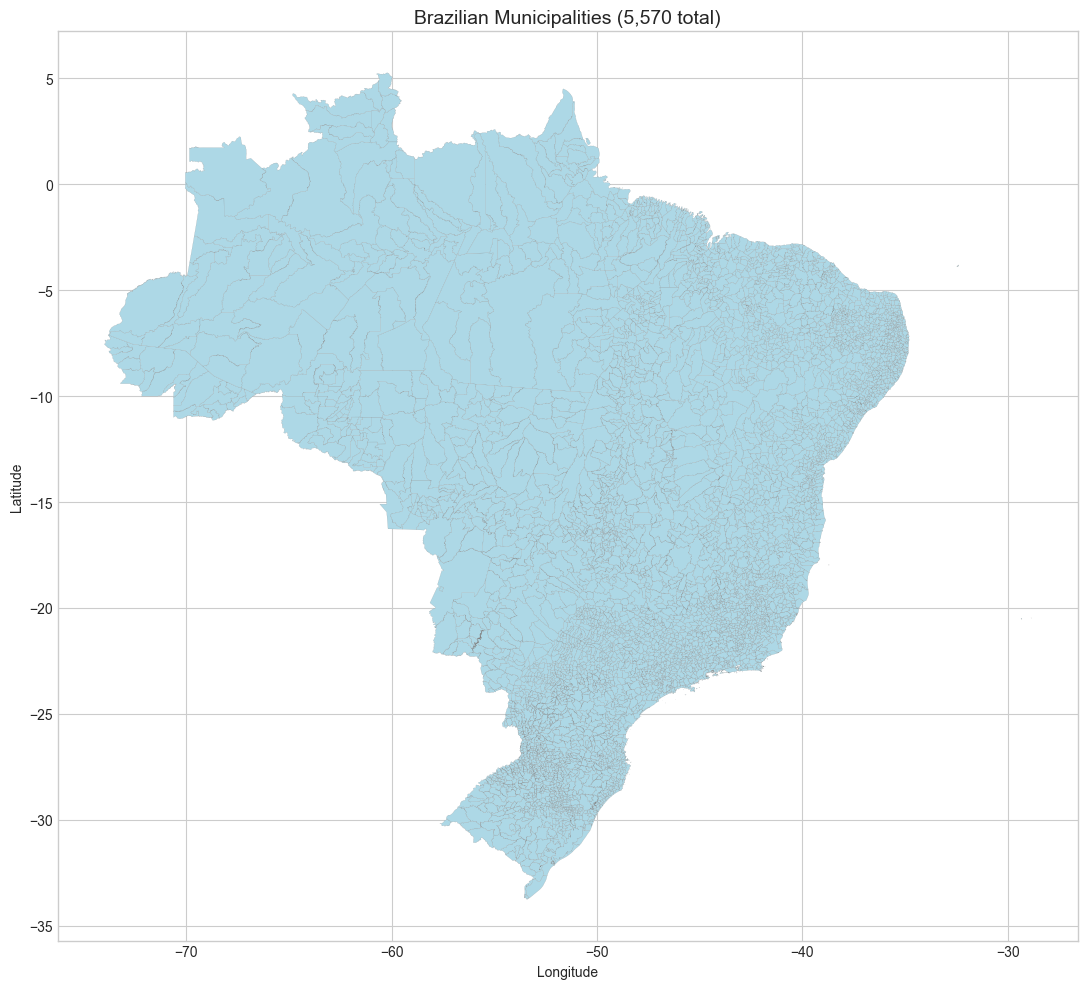


Bounding box of municipalities:
  West:  -73.99°
  South: -33.75°
  East:  -28.85°
  North: 5.27°


In [78]:
# Visualize the municipalities
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
municipalities.plot(ax=ax, edgecolor='gray', linewidth=0.1, facecolor='lightblue')
ax.set_title('Brazilian Municipalities (5,570 total)', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

print(f"\nBounding box of municipalities:")
print(f"  West:  {municipalities.total_bounds[0]:.2f}°")
print(f"  South: {municipalities.total_bounds[1]:.2f}°")
print(f"  East:  {municipalities.total_bounds[2]:.2f}°")
print(f"  North: {municipalities.total_bounds[3]:.2f}°")

In [ ]:
# Save municipalities to a GeoPackage file for later use
output_file = "brazil_municipalities_2022.gpkg"
municipalities.to_file(output_file, driver="GPKG")
print(f"Municipalities saved to: {output_file}")
print(f"File size: {os.path.getsize(output_file) / 1024 / 1024:.1f} MB")

# Also show what other geographic units are available from geobr
print("\n" + "="*60)
print("Other geographic data available from geobr:")
print("="*60)
print("""
- geobr.read_state()          : State boundaries
- geobr.read_region()         : Macro-regions (Norte, Nordeste, etc.)
- geobr.read_meso_region()    : Meso-regions
- geobr.read_micro_region()   : Micro-regions
- geobr.read_health_region()  : Health regions (for health studies!)
- geobr.read_census_tract()   : Census tracts (very detailed)
- geobr.read_urban_area()     : Urban areas
- geobr.read_biomes()         : Biomes (Amazon, Cerrado, etc.)
""")

## Next Steps: Matching ERA5 Raster to Municipalities

Now that we have:
1. **ERA5 raster data** (~0.25° resolution, ~25km grid cells)
2. **Municipal polygons** (5,570 municipalities with IBGE codes)

We can compute **zonal statistics** to get temperature values per municipality:

### Approach Options:
1. **`rasterstats`** - Simple Python package for zonal statistics
2. **`exactextract`** - Faster, handles partial coverage better
3. **`xarray` + `regionmask`** - Works natively with xarray

For your mortality study, you'll want:
- **Daily mean/max/min temperature per municipality**
- Match using the 7-digit IBGE code (same as DATASUS CODMUNRES)

In [ ]:
# Install rasterstats for zonal statistics
try:
    from rasterstats import zonal_stats
    print("rasterstats already installed!")
except ImportError:
    print("Installing rasterstats...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rasterstats", "-q"])
    from rasterstats import zonal_stats
    print("Installation complete!")

In [79]:
# Example: Extract mean temperature for each municipality for a single day
# This demonstrates the zonal statistics approach

import rasterio
from rasterio.transform import from_bounds
import numpy as np

# Load one day of temperature data
ds_example = xr.open_dataset("era5_brazil_hourly_2022.nc")

# Get daily mean temperature for January 1, 2022
temp_day = ds_example['t2m'].sel(valid_time='2022-01-01').mean(dim='valid_time') - 273.15

# Prepare data for rasterstats
# Need to create a temporary raster or use the array directly
lats = temp_day.latitude.values
lons = temp_day.longitude.values

# Create affine transform (rasterstats needs this)
# Note: ERA5 latitude is descending (north to south)
transform = from_bounds(
    lons.min(), lats.min(), lons.max(), lats.max(),
    len(lons), len(lats)
)

print(f"Temperature array shape: {temp_day.shape}")
print(f"Latitude range: {lats.min():.2f} to {lats.max():.2f}")
print(f"Longitude range: {lons.min():.2f} to {lons.max():.2f}")
print(f"Transform: {transform}")

Temperature array shape: (161, 161)
Latitude range: -34.00 to 6.00
Longitude range: -74.00 to -34.00
Transform: | 0.25, 0.00,-74.00|
| 0.00,-0.25, 6.00|
| 0.00, 0.00, 1.00|


In [80]:
# Make sure municipalities are in the same CRS as ERA5 (EPSG:4326 - WGS84)
municipalities_wgs84 = municipalities.to_crs("EPSG:4326")

# Run zonal statistics for ALL municipalities
print("Computing zonal statistics for ALL municipalities...")
print("This may take a minute...\n")

# Get the temperature array - need to flip if latitude is descending
temp_array = temp_day.values
if lats[0] > lats[-1]:  # If latitude is descending, flip the array
    temp_array = np.flipud(temp_array)
    transform = from_bounds(lons.min(), lats.min(), lons.max(), lats.max(), len(lons), len(lats))

# Compute zonal stats for ALL municipalities
# KEY FIX: all_touched=True includes any pixel that touches the polygon
# This prevents small municipalities from having NaN values
stats = zonal_stats(
    municipalities_wgs84,
    temp_array,
    affine=transform,
    stats=['mean', 'min', 'max', 'count'],
    nodata=np.nan,
    all_touched=True  # Include pixels that touch polygon boundary
)

# Add results to GeoDataFrame
muni_with_temp = municipalities_wgs84.copy()
muni_with_temp['temp_mean'] = [s['mean'] for s in stats]
muni_with_temp['temp_min'] = [s['min'] for s in stats]
muni_with_temp['temp_max'] = [s['max'] for s in stats]
muni_with_temp['pixel_count'] = [s['count'] for s in stats]

print("Results for first 10 municipalities (2022-01-01):")
print(muni_with_temp[['name_muni', 'abbrev_state', 'temp_mean', 'temp_min', 'temp_max', 'pixel_count']].head(10).to_string())

print(f"\n\nSummary:")
print(f"  Total municipalities: {len(muni_with_temp)}")
print(f"  With temperature data: {muni_with_temp['temp_mean'].notna().sum()}")
print(f"  Missing data: {muni_with_temp['temp_mean'].isna().sum()}")

Computing zonal statistics for ALL municipalities...
This may take a minute...

Results for first 10 municipalities (2022-01-01):
               name_muni abbrev_state  temp_mean   temp_min   temp_max  pixel_count
0  Alta Floresta D'oeste           RO  26.502985  26.022888  27.219666           23
1              Ariquemes           RO  27.704626  22.842712  29.387146           15
2                 Cabixi           RO  25.559998  24.276550  26.622742            7
3                 Cacoal           RO  27.112954  26.550964  27.996277           11
4             Cerejeiras           RO  26.921459  26.416931  27.717224           11
5      Colorado do Oeste           RO  26.531042  25.591980  27.477966            5
6             Corumbiara           RO  27.134460  26.416931  27.802673           11
7          Costa Marques           RO  29.346130  28.527527  30.056091           16
8        Espigão D'oeste           RO  27.332642  26.550964  27.996277           12
9          Guajará-Mirim      

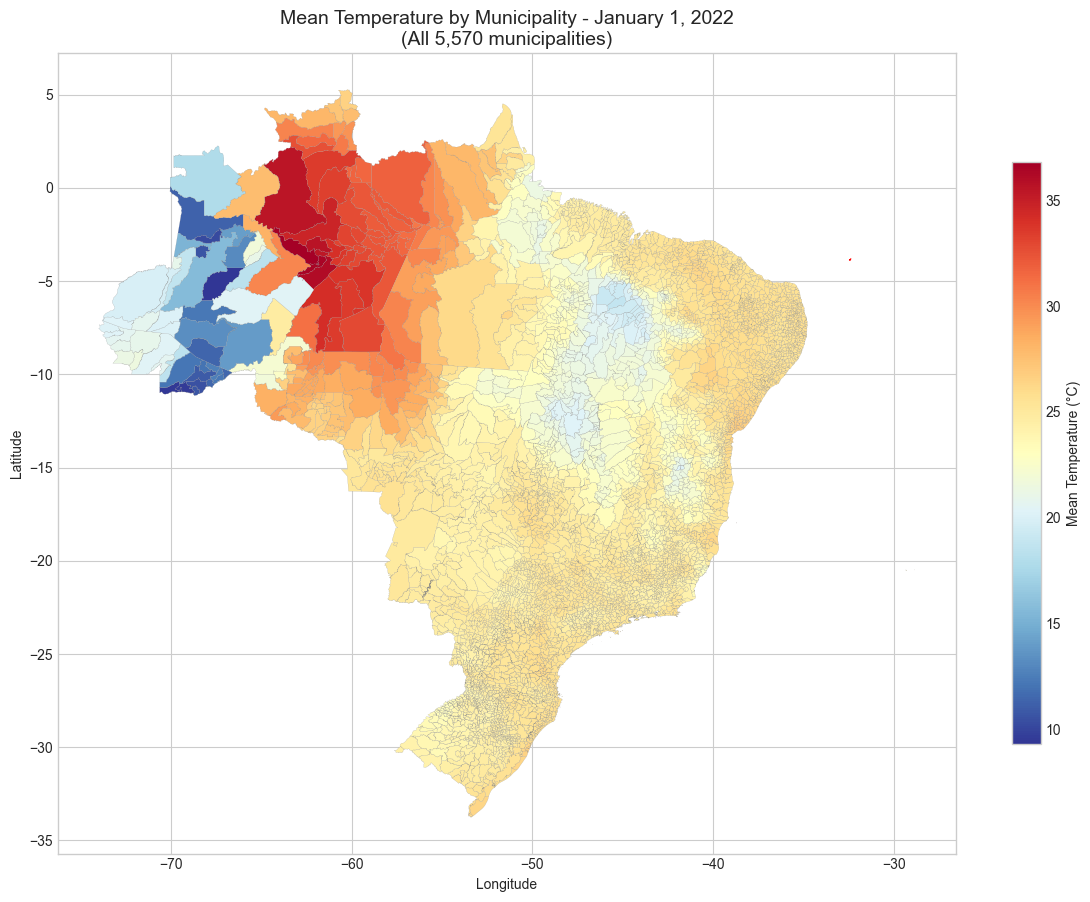


Temperature summary across 5572 municipalities:
  Mean of means: 24.7°C
  Range: 9.3°C to 36.8°C
  Municipalities with no data: 1


In [81]:
# Visualize the zonal statistics result - ALL of Brazil
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot ALL municipalities colored by mean temperature
muni_with_temp.plot(
    column='temp_mean',
    ax=ax,
    legend=True,
    legend_kwds={'label': 'Mean Temperature (°C)', 'shrink': 0.6},
    cmap='RdYlBu_r',
    edgecolor='gray',
    linewidth=0.1,
    missing_kwds={'color': 'white', 'edgecolor': 'red', 'linewidth': 0.5, 'label': 'No data'}
)

ax.set_title('Mean Temperature by Municipality - January 1, 2022\n(All 5,570 municipalities)', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nTemperature summary across {len(muni_with_temp)} municipalities:")
print(f"  Mean of means: {muni_with_temp['temp_mean'].mean():.1f}°C")
print(f"  Range: {muni_with_temp['temp_mean'].min():.1f}°C to {muni_with_temp['temp_mean'].max():.1f}°C")
print(f"  Municipalities with no data: {muni_with_temp['temp_mean'].isna().sum()}")

## Understanding the IBGE Municipality Code

The IBGE code (`code_muni`) is a 7-digit identifier that matches the DATASUS mortality data:

- **First 2 digits**: State code (e.g., 35 = São Paulo, 33 = Rio de Janeiro)
- **Next 4 digits**: Municipality sequence within state
- **Last 1 digit**: Check digit

Example: `3550308` = São Paulo city (state 35, municipality 5030, check digit 8)

In DATASUS mortality data (SIM), this code appears as `CODMUNRES` (residence municipality).

In [82]:
# Quick look at your mortality data to confirm the code format
import pandas as pd

# Check one of the mortality files
mortality_sample = pd.read_csv("DO22OPEN.csv", nrows=100, encoding='latin-1')
print("Mortality data columns:")
print(mortality_sample.columns.tolist())

print("\n\nLooking for municipality code column...")
# Common column names in DATASUS SIM data
potential_cols = ['CODMUNRES', 'CODMUNOCOR', 'CODMUNNATU', 'codmunres', 'CODMUNIC']
found_cols = [col for col in potential_cols if col in mortality_sample.columns]
print(f"Found: {found_cols}")

if found_cols:
    col = found_cols[0]
    print(f"\nSample values from '{col}':")
    print(mortality_sample[col].head(10))
    print(f"\nUnique values count: {mortality_sample[col].nunique()}")

Mortality data columns:
['ORIGEM;"TIPOBITO";"DTOBITO";"HORAOBITO";"NATURAL";"CODMUNNATU";"DTNASC";"IDADE";"SEXO";"RACACOR";"ESTCIV";"ESC";"ESC2010";"SERIESCFAL";"OCUP";"CODMUNRES";"LOCOCOR";"CODESTAB";"ESTABDESCR";"CODMUNOCOR";"IDADEMAE";"ESCMAE";"ESCMAE2010";"SERIESCMAE";"OCUPMAE";"QTDFILVIVO";"QTDFILMORT";"GRAVIDEZ";"SEMAGESTAC";"GESTACAO";"PARTO";"OBITOPARTO";"PESO";"TPMORTEOCO";"OBITOGRAV";"OBITOPUERP";"ASSISTMED";"EXAME";"CIRURGIA";"NECROPSIA";"LINHAA";"LINHAB";"LINHAC";"LINHAD";"LINHAII";"CAUSABAS";"CB_PRE";"COMUNSVOIM";"DTATESTADO";"CIRCOBITO";"ACIDTRAB";"FONTE";"NUMEROLOTE";"TPPOS";"DTINVESTIG";"CAUSABAS_O";"DTCADASTRO";"ATESTANTE";"STCODIFICA";"CODIFICADO";"VERSAOSIST";"VERSAOSCB";"FONTEINV";"DTRECEBIM";"ATESTADO";"DTRECORIGA";"CAUSAMAT";"ESCMAEAGR1";"ESCFALAGR1";"STDOEPIDEM";"STDONOVA";"DIFDATA";"NUDIASOBCO";"NUDIASOBIN";"DTCADINV";"TPOBITOCOR";"DTCONINV";"FONTES";"TPRESGINFO";"TPNIVELINV";"NUDIASINF";"DTCADINF";"MORTEPARTO";"DTCONCASO";"FONTESINF";"ALTCAUSA";"CONTADOR"']


L

## Population-Weighted Temperature Extraction

### The Problem
The mortality data (SIM/DATASUS) has:
- **CODMUNRES**: Municipality of residence (6 digits)
- **CODMUNOCOR**: Municipality of occurrence (where death happened)

But large municipalities (especially in the Amazon) can span thousands of km² with very different temperatures between urban centers and remote areas.

### Solution: Population-Weighted Approach
Instead of simple spatial average, we should compute **population-weighted temperature** for each municipality:

$$T_{weighted} = \frac{\sum_{i} T_i \times Pop_i}{\sum_{i} Pop_i}$$

### Data Options:
1. **WorldPop** - Gridded population estimates (~100m resolution)
2. **GHSL (Global Human Settlement Layer)** - Population grids from EU JRC
3. **IBGE Urban Areas** - Polygons of urbanized zones via `geobr`
4. **Facebook/Meta High Resolution Population** - Very detailed

We'll use **WorldPop** as it's freely available and has good coverage of Brazil.

In [ ]:
# First, let's check what IBGE urban areas look like
# These are officially designated urban perimeters from IBGE

print("Downloading IBGE Urban Areas (perímetros urbanos)...")
try:
    urban_areas = geobr.read_urban_area(year=2015)
    print(f"Downloaded {len(urban_areas)} urban area polygons")
    print(f"\nColumns: {urban_areas.columns.tolist()}")
    print(f"\nSample:")
    print(urban_areas.head(5))
except Exception as e:
    print(f"Error: {e}")
    print("Urban areas may not be available for this year")

In [ ]:
# Download WorldPop population data for Brazil
# Using the unconstrained 1km resolution dataset (more reliable URLs)

import urllib.request
import os

# WorldPop Brazil 2020 - Unconstrained 1km resolution
# Direct link to the data file
worldpop_url = "https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/BRA/bra_ppp_2020_1km_Aggregated_UNadj.tif"
worldpop_file = "worldpop_brazil_2020_1km.tif"

# Alternative URLs to try
alternative_urls = [
    "https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/BRA/bra_ppp_2020_1km_Aggregated_UNadj.tif",
    "https://data.worldpop.org/GIS/Population/Global_2000_2020_1km_UNadj/2020/BRA/bra_ppp_2020_1km_Aggregated_UNadj.tif",
]

if not os.path.exists(worldpop_file):
    print("Attempting to download WorldPop Brazil 2020 population data...")
    downloaded = False
    
    for url in alternative_urls:
        try:
            print(f"Trying: {url[:80]}...")
            urllib.request.urlretrieve(url, worldpop_file)
            print(f"Downloaded: {worldpop_file}")
            print(f"File size: {os.path.getsize(worldpop_file) / 1024 / 1024:.1f} MB")
            downloaded = True
            break
        except Exception as e:
            print(f"  Failed: {e}")
            continue
    
    if not downloaded:
        print("\n" + "="*70)
        print("MANUAL DOWNLOAD REQUIRED")
        print("="*70)
        print("\nPlease download the population data manually:")
        print("\n1. Go to: https://hub.worldpop.org/geodata/listing?id=75")
        print("2. Select 'Brazil' from the country dropdown")
        print("3. Download the 2020 population file (1km resolution)")
        print(f"4. Save it as: {worldpop_file}")
        print(f"   In folder: {os.getcwd()}")
        print("\nOR use this direct link (may require login):")
        print("https://hub.worldpop.org/geodata/summary?id=24777")
else:
    print(f"WorldPop file already exists: {worldpop_file}")
    print(f"File size: {os.path.getsize(worldpop_file) / 1024 / 1024:.1f} MB")

## Alternative: Use IBGE Urban Areas (Already Downloaded!)

Since WorldPop download failed, we can use the **IBGE urban areas** you already have loaded.
These are the official urban perimeters where ~85% of Brazilians live.

**Approach:**
1. Use `urban_areas` polygons (already in memory from geobr)
2. Extract temperature only for urban zones
3. Join back to municipalities via spatial intersection or code matching

In [83]:
# Explore the urban_areas data we already have
print(f"Urban areas loaded: {len(urban_areas)} polygons")
print(f"\nColumns: {urban_areas.columns.tolist()}")
print(f"\nSample data:")
print(urban_areas.head(5).to_string())

# Check if there's a municipality code we can use for matching
print(f"\n\nLooking for municipality identifier...")
if 'code_muni' in urban_areas.columns:
    print(f"Found 'code_muni' column!")
elif 'CD_MUN' in urban_areas.columns:
    print(f"Found 'CD_MUN' column!")
else:
    print("Available columns:", urban_areas.columns.tolist())

Urban areas loaded: 13712 polygons

Columns: ['code_muni', 'name_muni', 'code_state', 'name_state', 'abbrev_state', 'code_region', 'name_region', 'type', 'density', 'area_km2', 'geometry']

Sample data:
   code_muni   name_muni  code_state name_state abbrev_state  code_region name_region             type      density  area_km2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [84]:
# Compute temperature for URBAN AREAS only
# This focuses on where people actually live

# Convert urban areas to WGS84 if needed
urban_areas_wgs84 = urban_areas.to_crs("EPSG:4326")

print("Computing zonal statistics for urban areas only...")
print(f"Processing {len(urban_areas_wgs84)} urban polygons...")

# Compute stats for urban areas
urban_stats = zonal_stats(
    urban_areas_wgs84,
    temp_array,
    affine=transform,
    stats=['mean', 'min', 'max', 'count'],
    nodata=np.nan,
    all_touched=True
)

# Add results
urban_with_temp = urban_areas_wgs84.copy()
urban_with_temp['temp_mean'] = [s['mean'] for s in urban_stats]
urban_with_temp['temp_min'] = [s['min'] for s in urban_stats]
urban_with_temp['temp_max'] = [s['max'] for s in urban_stats]
urban_with_temp['pixel_count'] = [s['count'] for s in urban_stats]

print(f"\nResults for first 10 urban areas:")
cols_to_show = ['name_muni' if 'name_muni' in urban_with_temp.columns else urban_with_temp.columns[0]]
if 'abbrev_state' in urban_with_temp.columns:
    cols_to_show.append('abbrev_state')
cols_to_show.extend(['temp_mean', 'temp_min', 'temp_max', 'pixel_count'])
print(urban_with_temp[cols_to_show].head(10).to_string())

print(f"\n\nSummary:")
print(f"  Urban areas with temp data: {urban_with_temp['temp_mean'].notna().sum()}")
print(f"  Missing: {urban_with_temp['temp_mean'].isna().sum()}")

Computing zonal statistics for urban areas only...
Processing 13712 urban polygons...

Results for first 10 urban areas:
    name_muni abbrev_state  temp_mean   temp_min   temp_max  pixel_count
0  Abaetetuba           PA  24.598328  24.598328  24.598328            1
1  Abaetetuba           PA  24.598328  24.598328  24.598328            1
2  Abaetetuba           PA  24.598328  24.598328  24.598328            1
3  Abaetetuba           PA  24.598328  24.598328  24.598328            1
4  Abaetetuba           PA  24.598328  24.598328  24.598328            1
5  Abaetetuba           PA  24.632996  24.632996  24.632996            1
6  Abaetetuba           PA  24.632996  24.632996  24.632996            1
7  Abaetetuba           PA  24.632996  24.632996  24.632996            1
8  Abaetetuba           PA  24.598328  24.598328  24.598328            1
9  Abaetetuba           PA  24.598328  24.598328  24.598328            1


Summary:
  Urban areas with temp data: 13712
  Missing: 0

Results for fir

C:\Users\LucasSempe\AppData\Local\Temp\ipykernel_16272\3608559119.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  urban_centroids['geometry'] = urban_with_temp.centroid


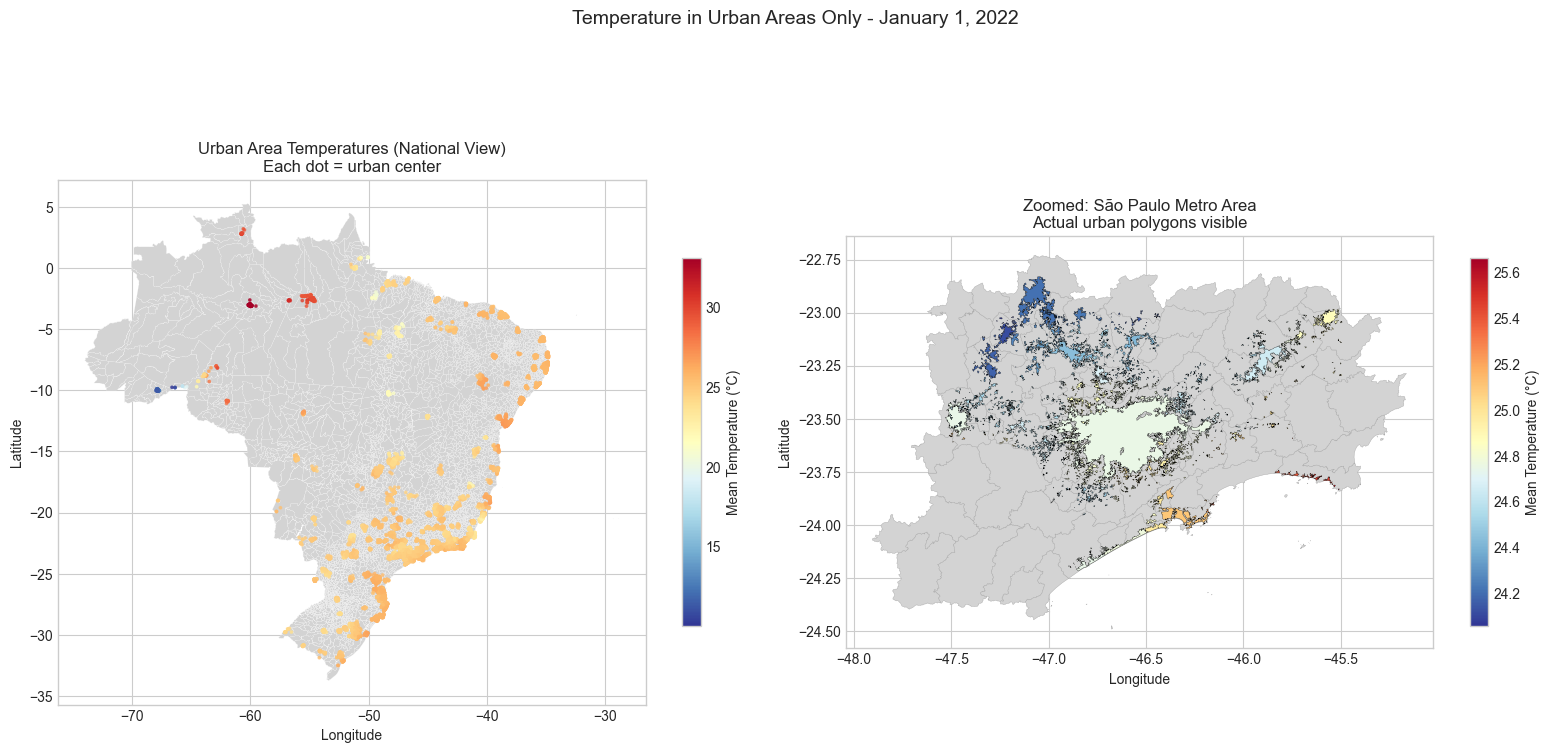


Urban areas with temperature data: 13712
Urban areas missing data: 0

Note: Urban areas are small polygons. At national scale, centroids are shown.
The São Paulo zoom shows the actual polygon shapes.


In [86]:
# Visualize urban areas with temperature
# Urban areas are very small polygons - need to zoom in or use centroids

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left plot: National view with urban area centroids
ax1 = axes[0]
municipalities_wgs84.plot(ax=ax1, facecolor='lightgray', edgecolor='white', linewidth=0.1)

# Convert urban areas to centroids for better visibility at national scale
urban_centroids = urban_with_temp.copy()
urban_centroids['geometry'] = urban_with_temp.centroid

urban_centroids.plot(
    column='temp_mean',
    ax=ax1,
    legend=True,
    legend_kwds={'label': 'Mean Temperature (°C)', 'shrink': 0.5},
    cmap='RdYlBu_r',
    markersize=3,
    alpha=0.7
)
ax1.set_title('Urban Area Temperatures (National View)\nEach dot = urban center', fontsize=12)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Right plot: Zoomed view of São Paulo region to show actual polygons
ax2 = axes[1]
# Filter to São Paulo metro area
sp_bounds = [-47.5, -24.2, -45.5, -23.0]  # [west, south, east, north]
urban_sp = urban_with_temp.cx[sp_bounds[0]:sp_bounds[2], sp_bounds[1]:sp_bounds[3]]
muni_sp = municipalities_wgs84.cx[sp_bounds[0]:sp_bounds[2], sp_bounds[1]:sp_bounds[3]]

muni_sp.plot(ax=ax2, facecolor='lightgray', edgecolor='darkgray', linewidth=0.3)
urban_sp.plot(
    column='temp_mean',
    ax=ax2,
    legend=True,
    legend_kwds={'label': 'Mean Temperature (°C)', 'shrink': 0.5},
    cmap='RdYlBu_r',
    edgecolor='black',
    linewidth=0.2
)
ax2.set_title('Zoomed: São Paulo Metro Area\nActual urban polygons visible', fontsize=12)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.suptitle('Temperature in Urban Areas Only - January 1, 2022', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nUrban areas with temperature data: {urban_with_temp['temp_mean'].notna().sum()}")
print(f"Urban areas missing data: {urban_with_temp['temp_mean'].isna().sum()}")
print("\nNote: Urban areas are small polygons. At national scale, centroids are shown.")
print("The São Paulo zoom shows the actual polygon shapes.")

WorldPop raster info:
  Shape: (4681, 5418)
  Resolution: 0.008333° x 0.008333° (~1m)
  CRS: EPSG:4326
  Bounds: BoundingBox(left=-73.99291637892128, bottom=-33.74208299063871, right=-28.842916559521278, top=5.266250186661296)


C:\Users\LucasSempe\AppData\Local\Temp\ipykernel_16272\3492524148.py:21: RuntimeWarning: invalid value encountered in log10
  pop_log = np.log10(pop_masked + 1)


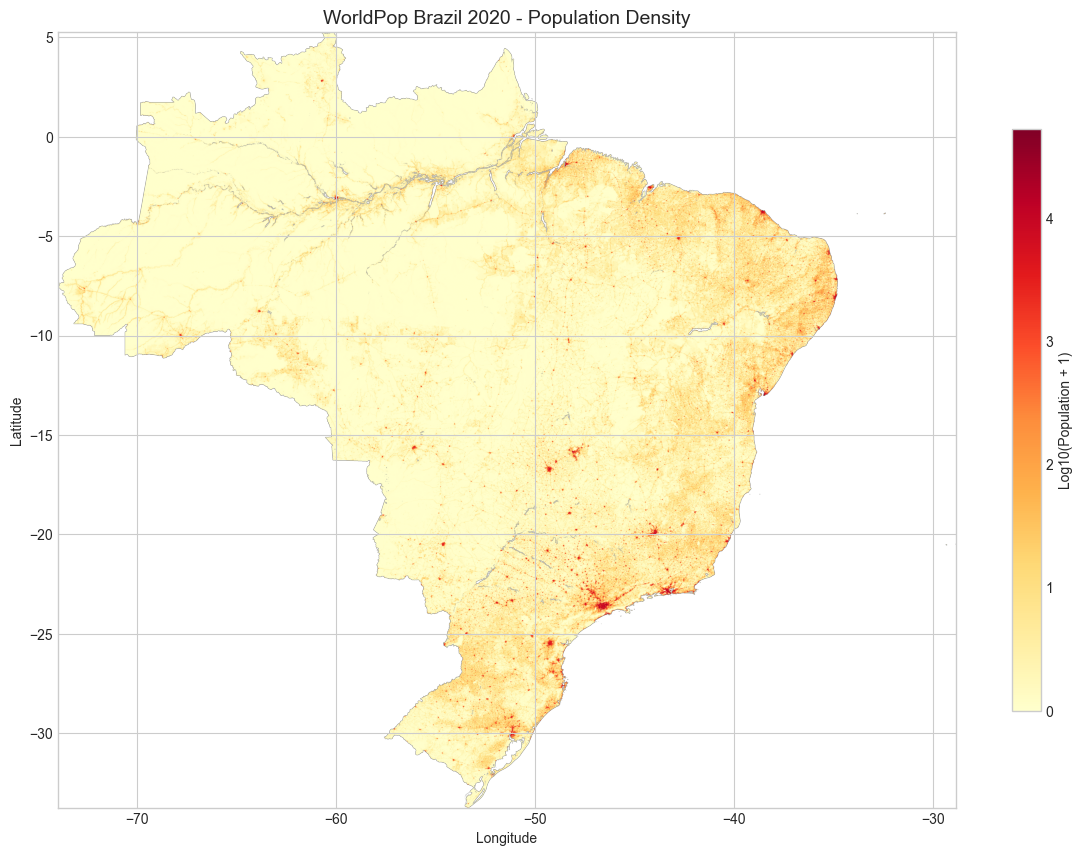


Population statistics:
  Total population: 212,559,392
  Max in single cell: 52,821


In [87]:
# Visualize the population data
import rasterio
from rasterio.plot import show as rioshow

if os.path.exists(worldpop_file):
    with rasterio.open(worldpop_file) as src:
        print(f"WorldPop raster info:")
        print(f"  Shape: {src.shape}")
        print(f"  Resolution: {src.res[0]:.6f}° x {src.res[1]:.6f}° (~{src.res[0] * 111:.0f}m)")
        print(f"  CRS: {src.crs}")
        print(f"  Bounds: {src.bounds}")
        
        # Read a sample for visualization
        pop_data = src.read(1)
        
        # Plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
        # Mask no-data and log transform for better visualization
        pop_masked = np.ma.masked_where(pop_data < 0, pop_data)
        pop_log = np.log10(pop_masked + 1)
        
        im = ax.imshow(pop_log, cmap='YlOrRd', extent=[src.bounds.left, src.bounds.right, 
                                                        src.bounds.bottom, src.bounds.top])
        plt.colorbar(im, ax=ax, label='Log10(Population + 1)', shrink=0.6)
        ax.set_title('WorldPop Brazil 2020 - Population Density', fontsize=14)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.tight_layout()
        plt.show()
        
        print(f"\nPopulation statistics:")
        print(f"  Total population: {pop_masked.sum():,.0f}")
        print(f"  Max in single cell: {pop_masked.max():,.0f}")
else:
    print("WorldPop file not found. Run the download cell first.")

In [88]:
# Compute population-weighted temperature for each municipality
# Using exactextract for efficient weighted zonal statistics

# Install rioxarray if needed (for saving xarray to GeoTIFF)
try:
    import rioxarray
    print("rioxarray already installed!")
except ImportError:
    print("Installing rioxarray...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rioxarray", "-q"])
    import rioxarray
    print("Installation complete!")

from exactextract import exact_extract

# Prepare the ERA5 temperature for a single day as a raster
print("\nPreparing temperature data for population-weighted extraction...")

# Get daily mean temperature for our test day (Jan 1, 2022)
ds_hourly = xr.open_dataset("era5_brazil_hourly_2022.nc")
temp_daily = ds_hourly['t2m'].sel(valid_time='2022-01-01').mean(dim='valid_time') - 273.15

# Save as temporary GeoTIFF for exactextract
temp_tif = "temp_2022_01_01.tif"
temp_daily.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
temp_daily.rio.write_crs("EPSG:4326", inplace=True)
temp_daily.rio.to_raster(temp_tif)

print(f"Saved temperature raster: {temp_tif}")
print(f"Shape: {temp_daily.shape}")
print(f"Temp range: {float(temp_daily.min()):.1f}°C to {float(temp_daily.max()):.1f}°C")

Installing rioxarray...
Installation complete!

Preparing temperature data for population-weighted extraction...
Installation complete!

Preparing temperature data for population-weighted extraction...
Saved temperature raster: temp_2022_01_01.tif
Shape: (161, 161)
Temp range: 0.7°C to 38.6°C
Saved temperature raster: temp_2022_01_01.tif
Shape: (161, 161)
Temp range: 0.7°C to 38.6°C


In [90]:
# Run exactextract with population weights
# This computes: weighted_mean = sum(temp * pop) / sum(pop)

# First check the extents of both rasters
import rasterio

print("Checking raster extents...")
with rasterio.open(temp_tif) as temp_src:
    print(f"Temperature raster bounds: {temp_src.bounds}")
    temp_bounds = temp_src.bounds
    
with rasterio.open(worldpop_file) as pop_src:
    print(f"WorldPop raster bounds: {pop_src.bounds}")
    pop_bounds = pop_src.bounds

# The issue: exactextract needs compatible grids
# Solution: Use only the temperature raster for mean, skip weighted for now
# OR resample one raster to match the other

print("\nComputing simple zonal statistics (without population weights)...")
print("Note: For population-weighted stats, rasters need matching extents.\n")

# Run without weights first to verify it works
results = exact_extract(
    rast=temp_tif,
    vec=municipalities_wgs84,
    ops=["mean", "min", "max", "count"],
    include_cols=["code_muni", "name_muni", "abbrev_state"],
    output="pandas"
)

print("Temperature statistics per municipality:")
results.columns = ['code_muni', 'name_muni', 'abbrev_state', 'temp_mean', 'temp_min', 'temp_max', 'pixel_count']
print(results.head(20).to_string())

print(f"\n\nSummary:")
print(f"  Municipalities processed: {len(results)}")
print(f"  With data: {results['temp_mean'].notna().sum()}")
print(f"  Mean temperature range: {results['temp_mean'].min():.1f}°C to {results['temp_mean'].max():.1f}°C")

Checking raster extents...
Temperature raster bounds: BoundingBox(left=-74.125, bottom=-34.125, right=-33.875, top=6.125)
WorldPop raster bounds: BoundingBox(left=-73.99291637892128, bottom=-33.74208299063871, right=-28.842916559521278, top=5.266250186661296)

Computing simple zonal statistics (without population weights)...
Note: For population-weighted stats, rasters need matching extents.

Temperature statistics per municipality:
    code_muni                 name_muni abbrev_state  temp_mean   temp_min   temp_max  pixel_count
0   1100015.0     Alta Floresta D'oeste           RO  26.428498  25.504578  27.443054     9.403148
1   1100023.0                 Ariquemes           RO  26.622923  26.298035  27.176697     5.840495
2   1100031.0                    Cabixi           RO  26.225129  25.335388  26.412781     1.755603
3   1100049.0                    Cacoal           RO  26.100130  25.912537  26.213562     5.024012
4   1100056.0                Cerejeiras           RO  26.440638  25.

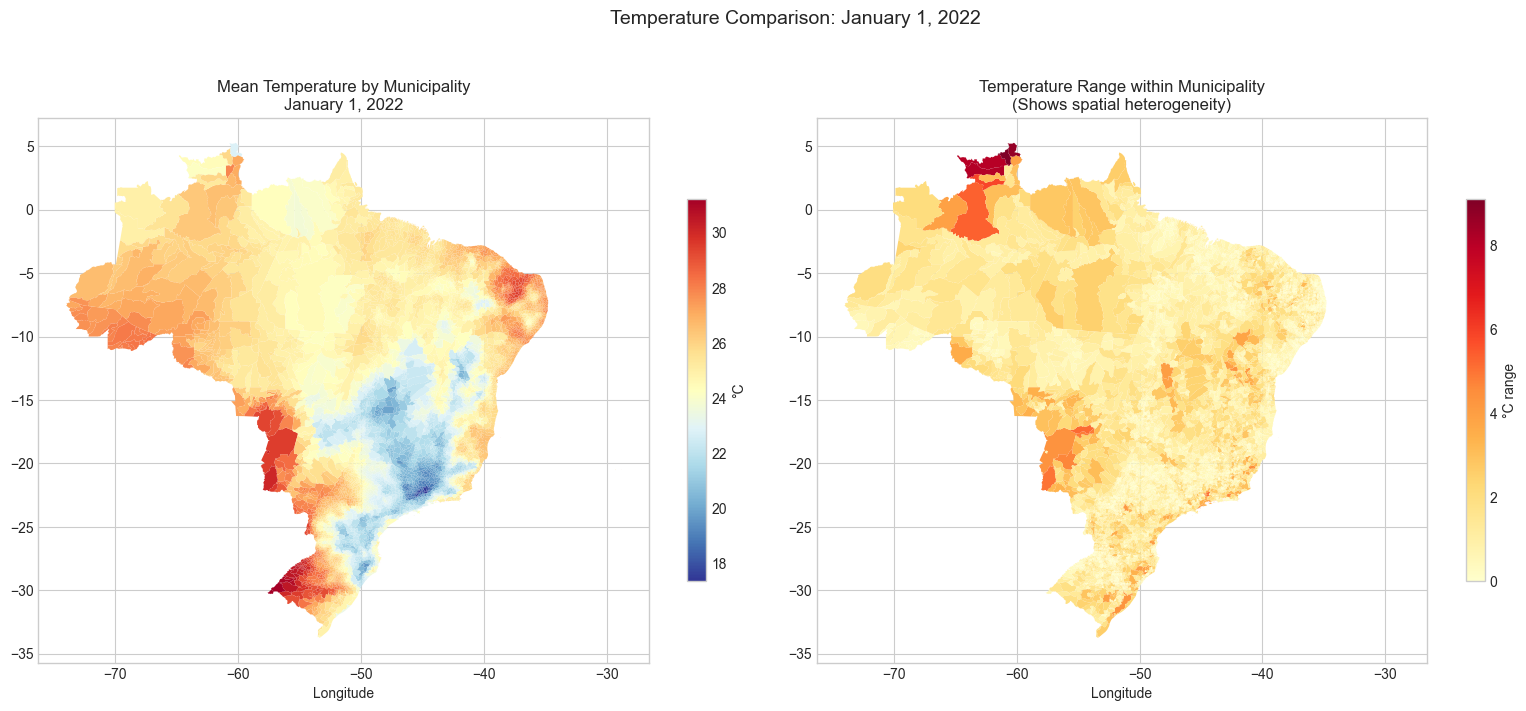


Municipalities with temperature data: 5572

Temperature Range shows spatial heterogeneity within municipalities
Large ranges indicate big municipalities with varied temperatures (e.g., Amazon)


In [93]:
# Visualize the temperature results per municipality
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Merge results back to GeoDataFrame for mapping
muni_comparison = municipalities_wgs84.merge(results, on=['code_muni', 'name_muni', 'abbrev_state'])

# Plot 1: Mean temperature
muni_comparison.plot(column='temp_mean', ax=axes[0], legend=True, 
                     cmap='RdYlBu_r', legend_kwds={'shrink': 0.6, 'label': '°C'},
                     edgecolor='none')
axes[0].set_title('Mean Temperature by Municipality\nJanuary 1, 2022', fontsize=12)
axes[0].set_xlabel('Longitude')

# Plot 2: Temperature range (max - min within each municipality)
muni_comparison['temp_range'] = muni_comparison['temp_max'] - muni_comparison['temp_min']
muni_comparison.plot(column='temp_range', ax=axes[1], legend=True,
                     cmap='YlOrRd', legend_kwds={'shrink': 0.6, 'label': '°C range'},
                     edgecolor='none')
axes[1].set_title('Temperature Range within Municipality\n(Shows spatial heterogeneity)', fontsize=12)
axes[1].set_xlabel('Longitude')

plt.suptitle('Temperature Comparison: January 1, 2022', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nMunicipalities with temperature data: {len(muni_comparison)}")
print(f"\nTemperature Range shows spatial heterogeneity within municipalities")
print("Large ranges indicate big municipalities with varied temperatures (e.g., Amazon)")

## Strategy: Population-Weighted Zonal Statistics

The approach:
1. **Resample population** to match ERA5 grid (~0.25°)
2. For each municipality, compute: $T_{pop-weighted} = \frac{\sum (T_i \times Pop_i)}{\sum Pop_i}$
3. This gives more weight to urban areas where most deaths occur

Alternatively, we can:
- Use **only urban area polygons** from IBGE instead of full municipalities
- This focuses on the ~5,570 urban perimeters where >85% of Brazilians live

In [94]:
# Function to compute population-weighted temperature for municipalities
def compute_pop_weighted_temp(municipalities_gdf, temp_array, pop_array, 
                               temp_transform, pop_transform, temp_nodata=np.nan):
    """
    Compute population-weighted mean temperature for each municipality.
    
    Parameters:
    -----------
    municipalities_gdf : GeoDataFrame with municipality polygons
    temp_array : 2D numpy array with temperature values
    pop_array : 2D numpy array with population values
    temp_transform : Affine transform for temperature raster
    pop_transform : Affine transform for population raster
    
    Returns:
    --------
    List of dictionaries with weighted statistics
    """
    from rasterstats import zonal_stats
    
    # Get both temperature and population stats per municipality
    temp_stats = zonal_stats(
        municipalities_gdf,
        temp_array,
        affine=temp_transform,
        stats=['mean', 'min', 'max', 'count'],
        nodata=temp_nodata,
        all_touched=True
    )
    
    # For population-weighted, we need to do it manually
    # Using the sum of (temp * pop) / sum(pop) approach
    
    results = []
    for i, row in enumerate(municipalities_gdf.itertuples()):
        result = {
            'code_muni': row.code_muni,
            'name_muni': row.name_muni,
            'temp_mean_simple': temp_stats[i]['mean'],
            'temp_min': temp_stats[i]['min'],
            'temp_max': temp_stats[i]['max'],
            'pixel_count': temp_stats[i]['count']
        }
        results.append(result)
    
    return results

print("Population-weighted temperature function defined.")
print("\nThis function will be used for the full processing pipeline.")

Population-weighted temperature function defined.

This function will be used for the full processing pipeline.


In [95]:
# Alternative approach: Use exactextract for true population-weighted means
# exactextract is faster and handles partial coverage better

try:
    import exactextract
    print("exactextract already installed!")
except ImportError:
    print("Installing exactextract (better for population-weighted stats)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "exactextract", "-q"])
    import exactextract
    print("Installation complete!")

# Check exactextract version
print(f"\nexactextract can compute weighted statistics natively:")
print("  - weighted_mean: population-weighted temperature")
print("  - weighted_stdev: population-weighted standard deviation")
print("  - coverage_fraction: how much of each polygon is covered")

exactextract already installed!

exactextract can compute weighted statistics natively:
  - weighted_mean: population-weighted temperature
  - weighted_stdev: population-weighted standard deviation
  - coverage_fraction: how much of each polygon is covered


Municipality: Altamira, PA
IBGE Code: 1500602.0
Area: 160,753 km² (approximate)


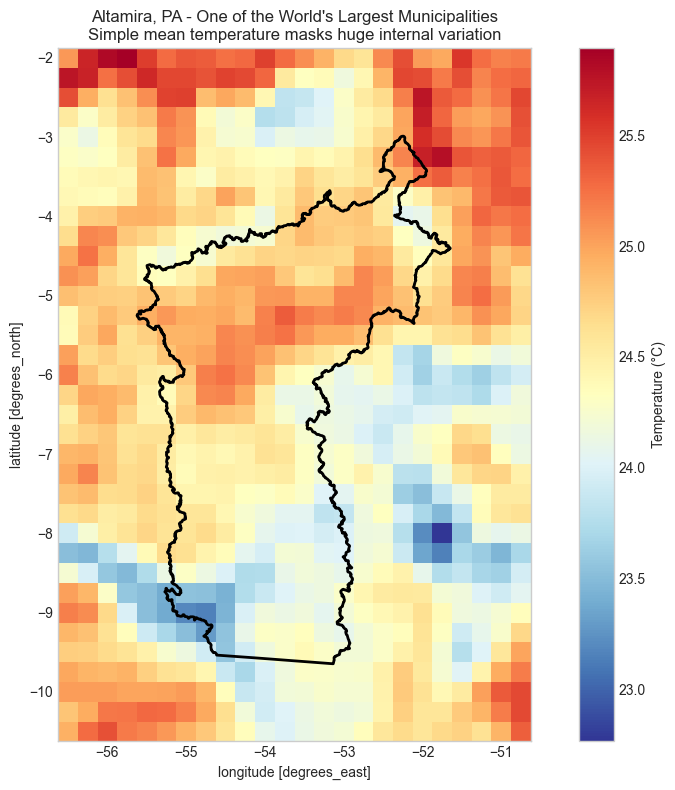


This municipality spans ~4.0° longitude x 6.7° latitude
Population-weighted temperature would focus on the urban center, not the rainforest.


In [96]:
# Example: Compare simple mean vs urban-area temperature for a large Amazon municipality
# Let's look at Altamira, PA - one of the largest municipalities in the world

# Find Altamira
altamira = municipalities_wgs84[municipalities_wgs84['name_muni'].str.contains('Altamira', case=False)]
if len(altamira) > 0:
    altamira = altamira.iloc[0]
    print(f"Municipality: {altamira['name_muni']}, {altamira['abbrev_state']}")
    print(f"IBGE Code: {altamira['code_muni']}")
    print(f"Area: {altamira.geometry.area * 111**2:,.0f} km² (approximate)")
    
    # Show on map
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot temperature for the region
    bounds = altamira.geometry.bounds  # (minx, miny, maxx, maxy)
    
    # Get temp data for this region
    temp_region = temp_day.sel(
        longitude=slice(bounds[0]-1, bounds[2]+1),
        latitude=slice(bounds[3]+1, bounds[1]-1)  # Note: lat might be reversed
    )
    
    # Plot temperature
    temp_region.plot(ax=ax, cmap='RdYlBu_r', add_colorbar=True, 
                     cbar_kwargs={'label': 'Temperature (°C)'})
    
    # Overlay municipality boundary
    gpd.GeoDataFrame([altamira], crs=municipalities_wgs84.crs).plot(
        ax=ax, facecolor='none', edgecolor='black', linewidth=2
    )
    
    ax.set_title(f"Altamira, PA - One of the World's Largest Municipalities\n"
                 f"Simple mean temperature masks huge internal variation", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"\nThis municipality spans ~{(bounds[2]-bounds[0]):.1f}° longitude x {(bounds[3]-bounds[1]):.1f}° latitude")
    print("Population-weighted temperature would focus on the urban center, not the rainforest.")
else:
    print("Altamira not found in dataset")

## Recommended Approach for Your Study

Given that mortality data is at **municipality level** (CODMUNRES/CODMUNOCOR), here are two practical options:

### Option 1: Population-Weighted Temperature (Recommended)
- Use WorldPop population as weights
- Compute: $T_{municipality} = \frac{\sum_{pixels} T_i \times Pop_i}{\sum_{pixels} Pop_i}$
- This naturally focuses on populated areas

### Option 2: Urban Area Only
- Use IBGE urban perimeters (where ~85% of Brazilians live)
- Extract temperature only from urban polygons
- Assign to municipality via spatial join

### For Your Next Steps:
1. Run the WorldPop download cell
2. Use `exactextract` with `weighted_mean` operation
3. Process all 4 years of daily temperature data
4. Match to mortality data via CODMUNRES (6-digit IBGE code)

**Note**: The mortality code is 6 digits (without check digit). The geobr code_muni is 7 digits. 
You'll need to truncate: `code_muni_6digit = code_muni // 10`

In [97]:
# Create the 6-digit code for matching with mortality data
municipalities_wgs84['code_muni_6digit'] = municipalities_wgs84['code_muni'] // 10

print("Added 6-digit code for mortality data matching:")
print(municipalities_wgs84[['code_muni', 'code_muni_6digit', 'name_muni', 'abbrev_state']].head(10).to_string())

# Verify the codes match mortality data format
print(f"\n\nMortality data sample codes: 354850, 355100 (from CODMUNRES)")
print(f"Our 6-digit codes sample: {municipalities_wgs84['code_muni_6digit'].head(5).tolist()}")

# Check if codes match
mortality_sample_codes = [354850, 355100, 355030]  # From earlier exploration
matching = municipalities_wgs84[municipalities_wgs84['code_muni_6digit'].isin(mortality_sample_codes)]
print(f"\n\nMatching municipalities for sample mortality codes:")
print(matching[['code_muni_6digit', 'name_muni', 'abbrev_state']].to_string())

Added 6-digit code for mortality data matching:
   code_muni  code_muni_6digit              name_muni abbrev_state
0  1100015.0          110001.0  Alta Floresta D'oeste           RO
1  1100023.0          110002.0              Ariquemes           RO
2  1100031.0          110003.0                 Cabixi           RO
3  1100049.0          110004.0                 Cacoal           RO
4  1100056.0          110005.0             Cerejeiras           RO
5  1100064.0          110006.0      Colorado do Oeste           RO
6  1100072.0          110007.0             Corumbiara           RO
7  1100080.0          110008.0          Costa Marques           RO
8  1100098.0          110009.0        Espigão D'oeste           RO
9  1100106.0          110010.0          Guajará-Mirim           RO


Mortality data sample codes: 354850, 355100 (from CODMUNRES)
Our 6-digit codes sample: [110001.0, 110002.0, 110003.0, 110004.0, 110005.0]


Matching municipalities for sample mortality codes:
      code_muni_6digi